In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm 
import warnings
import gc
import os 
import sys
from IPython.core.interactiveshell import  InteractiveShell
pd.set_option('max.rows',200)
pd.set_option('max.columns',100)
warnings.filterwarnings('ignore')
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = sns.light_palette('blue',as_cmap=True)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.mpl.rcParams['figure.figsize'] = (8.0, 4.0)

# display Chinese in pictures
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf',size=15)
sns.set(font=myfont.get_name())

# display minus operations 
sns.mpl.rcParams['axes.unicode_minus']=False

#### **DTW Corr Match Results Data**      

In [3]:
dtw_corr_mean_20 = pd.read_pickle('..//result//corr_mean_20')
dtw_corr_mean_30 = pd.read_pickle('..//result//corr_mean_30')       
dtw_corr_mean_40 = pd.read_pickle('..//result//corr_mean_40')        
dtw_corr_median_20 = pd.read_pickle('..//result//corr_median_20')
dtw_corr_median_30 = pd.read_pickle('..//result//corr_median_30') 
dtw_corr_median_40 = pd.read_pickle('..//result//corr_median_40')

#### **correlation threshold**

In [4]:
# # get sample percentage of valid data 
# 5 / len(dtw_corr[(dtw_corr['asset']=='石油石化')&(dtw_corr['test_start']=='2016-1-4')]) # 0.03759398496240601
# # choose quantile of 0.95 

In [5]:
dtw_corr_mean_20.quantile(0.95)
dtw_corr_mean_30.quantile(0.95)
dtw_corr_mean_40.quantile(0.95)
dtw_corr_median_20.quantile(0.95)
dtw_corr_median_30.quantile(0.95)
dtw_corr_median_40.quantile(0.95)

corr    0.930998
Name: 0.95, dtype: float64

corr    0.933526
Name: 0.95, dtype: float64

corr    0.933196
Name: 0.95, dtype: float64

corr    0.922163
Name: 0.95, dtype: float64

corr    0.92487
Name: 0.95, dtype: float64

corr    0.92514
Name: 0.95, dtype: float64

In [27]:
dtw_corr_mean_40

,asset,test_start,test_end,train_start,train_end,corr
0,石油石化,2016-1-4,2016-2-1,2004-12-31,2005-3-9,0.520844
1,煤炭,2016-1-4,2016-2-1,2004-12-31,2005-3-9,0.618723
2,有色金属,2016-1-4,2016-2-1,2004-12-31,2005-3-9,-0.029242
3,电力及公用事业,2016-1-4,2016-2-1,2004-12-31,2005-3-9,0.219900
4,钢铁,2016-1-4,2016-2-1,2004-12-31,2005-3-9,-0.065160
...,...,...,...,...,...,...
140935,电子,2020-11-10,2020-12-8,2020-8-20,2020-10-23,0.811785
140936,通信,2020-11-10,2020-12-8,2020-8-20,2020-10-23,0.930514
140937,计算机,2020-11-10,2020-12-8,2020-8-20,2020-10-23,0.866986
140938,传媒,2020-11-10,2020-12-8,2020-8-20,2020-10-23,0.860235


In [6]:
# dtw_corr['corr'].quantile(0.95) # 0.9309975900986858
threshold = 0.9
selected = dtw_corr_mean_20[dtw_corr_mean_20['corr']>threshold]

In [7]:
def countHeatmap(selected):
    # count by asset type and test period 
    count = selected.groupby(['asset','test_start'])['train_start'].count()
    selected_count = []
    for asset in count.index.get_level_values(0).drop_duplicates():
        selected_count.append(count.loc[asset])
    selected_count = pd.concat(selected_count,axis=1)
    selected_count.columns = count.index.get_level_values(0).drop_duplicates()
    
    # heatmap plot 
    # highlight missing value by white 
    plt.figure(figsize=(12,16))
    g = sns.heatmap(selected_count, cmap=cm, mask=selected_count.isnull())
    g.set_facecolor('white');
    
    return 

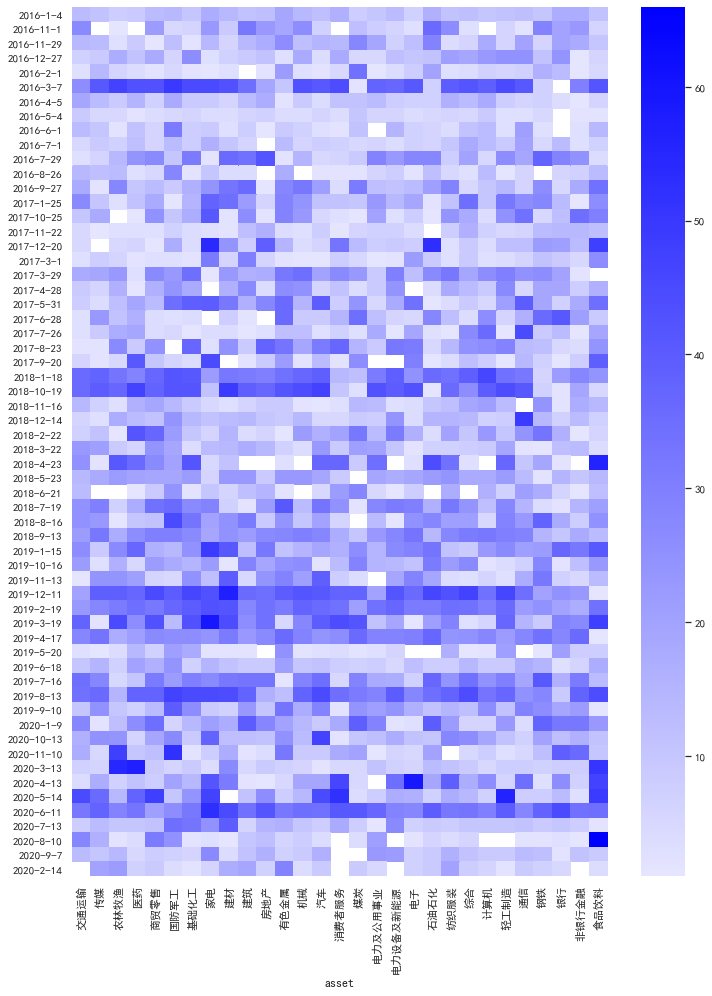

In [8]:
countHeatmap(selected)

time variance is larger than by asset variance           

## **Match**

### **Ⅰ By Industry Match**    

In [9]:
threshold = 0.9
dtw_corr_mean = pd.concat([dtw_corr_mean_20,dtw_corr_mean_30,dtw_corr_mean_40])
selected = dtw_corr_mean[dtw_corr_mean['corr']>threshold]
selected.set_index(['test_start','asset'],drop=True,inplace=True)

In [10]:
# # top 5 
# mean_corr = selected.groupby(['test_start','asset'])['corr'].mean()
# sort_result = mean_corr.groupby(level=[0]).apply(lambda x: x.sort_values(ascending=False).head(5))
# sort_result.index = sort_result.index.droplevel(0)
# match_by_industry = pd.merge(selected,sort_result,on=['test_start','asset'])[['test_end','train_end']].sort_index(level=[0])
# match_by_industry.to_pickle('..//result//match_by_industry')

In [14]:
selected.to_pickle('..//result//match_by_industry')

### **Ⅰ By Matrix Match**

In [15]:
valid_train_end = selected.groupby(['test_start','train_end'])['corr'].count()
valid_train_end.name = 'count'
valid_train_end = valid_train_end[valid_train_end>=10]

In [16]:
# display number of matched matrix 
pd.DataFrame(valid_train_end.groupby(level=[0]).count()).T.style.background_gradient(cmap=cm,axis=1)

test_start,2016-1-4,2016-11-1,2016-11-29,2016-12-27,2016-2-1,2016-3-7,2016-4-5,2016-5-4,2016-6-1,2016-7-1,2016-7-29,2016-8-26,2016-9-27,2017-1-25,2017-10-25,2017-11-22,2017-12-20,2017-3-1,2017-3-29,2017-4-28,2017-5-31,2017-6-28,2017-7-26,2017-8-23,2017-9-20,2018-1-18,2018-10-19,2018-11-16,2018-12-14,2018-2-22,2018-3-22,2018-4-23,2018-5-23,2018-6-21,2018-7-19,2018-8-16,2018-9-13,2019-1-15,2019-10-16,2019-11-13,2019-12-11,2019-2-19,2019-3-19,2019-4-17,2019-5-20,2019-6-18,2019-7-16,2019-8-13,2019-9-10,2020-1-9,2020-10-13,2020-11-10,2020-2-14,2020-3-13,2020-4-13,2020-5-14,2020-6-11,2020-7-13,2020-8-10,2020-9-7
count,27,27,32,29,15,75,22,15,15,17,47,8,44,42,25,13,27,8,53,33,59,20,21,54,12,74,76,25,22,37,33,53,41,10,61,45,61,68,39,29,85,72,80,64,9,25,64,84,40,50,38,25,22,28,50,55,75,24,5,20


In [19]:
selected

test_end train_start   train_end      corr
test_start asset                                             
2016-1-4   石油石化    2016-2-1  2004-12-31   2005-1-31  0.967259
           有色金属    2016-2-1  2004-12-31   2005-1-31  0.908756
           建筑      2016-2-1    2005-3-9    2005-4-6  0.919280
           建材      2016-2-1    2005-3-9    2005-4-6  0.939045
           轻工制造    2016-2-1    2005-3-9    2005-4-6  0.914883
...                     ...         ...         ...       ...
2020-11-10 机械     2020-12-8   2020-4-23   2020-6-23  0.935170
           交通运输   2020-12-8   2020-4-23   2020-6-23  0.940865
           有色金属   2020-12-8   2020-6-23   2020-8-20  0.926715
           国防军工   2020-12-8   2020-6-23   2020-8-20  0.914482
           通信     2020-12-8   2020-8-20  2020-10-23  0.930514

[68288 rows x 4 columns]

In [25]:
match_by_matrix = pd.merge(selected.reset_index(),valid_train_end,on=['test_start','train_end'],how='inner').drop('count',axis=1)

In [26]:
match_by_matrix.to_pickle('..//result//match_by_matrix')